In [ ]:
"""
 - get probability matrix
 - calculate randomwalk, wasserstein, symmetric KL, jaccard sp
 - plot results along with jaccard-shortest
"""

In [ ]:
from scipy.io import loadmat
from scipy.sparse import find
from scipy.sparse.csgraph import dijkstra
from scipy.linalg import sqrtm
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, to_tree
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import adjusted_rand_score
import numpy as np
import numpy.linalg as lalg
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
from pickle import dump, load, HIGHEST_PROTOCOL
%matplotlib inline

In [ ]:
def wrangle_karate():
    mat = loadmat('karate.mat')
    S = mat['Problem'][0][0][2]
    G = nx.Graph(S)

    mr_hi = set([1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22])
    split = {}
    cols = {}
    for i in G.nodes:
        split[i] = 0 if i+1 in mr_hi else 1
        cols[i] = (1,0,0,1) if i+1 in mr_hi else (0,0,0,1)
    nx.set_node_attributes(G, split, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.graph['name'] = 'karate'
    return G

In [ ]:
def wrangle_football():
    # data fixed by Tim Evans
    mat = loadmat('football_fixed.mat')
    I,J = mat['links']
    G = nx.Graph()
    G.add_edges_from(zip(I,J))

    confs = {}
    cols = {}
    cmap = plt.get_cmap('tab20')
    for node in mat['nodes']:
        idx = int(node[0])
        conf = int(node[2])
        assert idx not in confs.keys()
        if conf>10:
            confs[idx] = conf
            cols[idx] = (0,0,0,1)
        else:
            confs[idx] = conf
            cols[idx] = cmap(conf/11)
    nx.set_node_attributes(G, confs, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.graph['name'] = 'football'
    return G

In [ ]:
def wrangle_caltech():
    mat = loadmat('Caltech36.mat')
    G = nx.Graph(mat['A'])

    houses = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for i,x in enumerate(mat['local_info']):
        house = x[4]
        if house==0:
            houses[i] = house
            cols[i] = (0,0,0,1)
        else:
            houses[i] = house
            cols[i] = cmap((house-165)/10)
    nx.set_node_attributes(G, houses, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.graph['name'] = 'caltech'
    return G

In [ ]:
def generate_lfr():
    G = LFR_benchmark_graph(n=250, tau1=3, tau2=1.5, mu=.1, average_degree=5, min_community=20, seed=0)
    communities = nx.get_node_attributes(G, 'community')
    seen = set()
    clust_idx = 0
    clusts = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for idx,community in communities.items():
        if idx not in seen:
            for member in community:
                clusts[member] = clust_idx
                cols[member] = cmap(clust_idx/10)
                seen.add(member)
            clust_idx += 1
    nx.set_node_attributes(G, clusts, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    G.remove_edges_from(nx.selfloop_edges(G))
    G.graph['name'] = 'lfr'
    return G

In [ ]:
def largest_connected_component(G):
    G = G.subgraph(max(nx.connected_components(G), key=len))
    G = nx.relabel.convert_node_labels_to_integers(G, label_attribute='orig')
    return G

In [ ]:
def is_metric(dist, eps=0):
    square = squareform(dist)
    n,m = square.shape
    assert n==m
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if square[i,j] > square[i,k]+square[k,j]+eps:
                    print(f'{i} {j} {k}')
                    print(square[i,j])
                    print(square[i,k]+square[k,j])
                    return False
    return True

def draw_dendrogram(G, hierarchy):
    plt.figure(figsize=(20,5))
    plt.rcParams["font.weight"] = "bold"
    dend = dendrogram(hierarchy, leaf_rotation=90, leaf_font_size=8)

    ticks, labels = plt.xticks()
    for label in labels:
        idx = int(label.get_text())
        label.set_color(G.nodes[idx]['color'])
    plt.xticks(ticks, labels)

def eval_ARI(G, hierarchy):
    """calculates the adjusted rand index to evaluate cluster quality"""
    if hierarchy is None:
        return (-1, -1) # might happen if there are infinite distances so KL does not converge
    try:
        cut = cut_tree(hierarchy).transpose()
    except ValueError:
        return (-1, -2) # might happen if there are negative distances in tree due to non-metric
    
    attrs = nx.get_node_attributes(G, 'cluster')
    n = len(G)
    gtruth = []
    ignore = set() # unuseful labels are set to -1 earlier
    for idx,label in attrs.items():
        if label >= 0:
            gtruth.append(label)
        else:
            ignore.add(idx)
    labelset = set(gtruth)
    predicted = []
    
    # try cutting at every dendrogram branch
    best = -float('inf')
    argbest = -1
    for n_clust, clusters in enumerate(cut):
        score = adjusted_rand_score(gtruth, clusters)
        if score > best:
            best = score
            argbest = n_clust
    return best, n-argbest

In [24]:
# functions to create high dimensional embeddings based on markov chains

def embed_snapshot_markov(G, steps, degrees):
    '''embedding of pons & lapaty, including extra weighting using degrees'''
    # get markov matrix P
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    P = lalg.inv(D) @ A
    
    # steps
    P = lalg.matrix_power(P, steps)
    if degrees:
        P = lalg.inv(sqrtm(D)) @ P
    return P

def embed_damped_markov(G, damping, steps=100):
    '''weights each markov chain state according to a damping factor'''
    # get markov matrix P
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    P = lalg.inv(D) @ A
    
    # get weighted sum of all snapshots
    state = np.array(P)
    final = np.array(P)
    totaldamp = 1
    currdamp = damping
    for i in range(1,steps):
        state = state @ P
        final += currdamp * state
        totaldamp += currdamp
        currdamp *= damping
    final /= totaldamp
    return final

In [25]:
# linkage methods

def cluster_walktrap(embedding, opt_ord=False):
    dist = pdist(embedding, metric='euclidean')
    # print(is_metric(dist))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)
    
def KL_symmetric(embedding, opt_ord=False):
    if min(np.nditer(embedding)) <= 0:
        return None
    dist = pdist(embedding, metric=lambda x,y: entropy(x,y)+entropy(y,x))
    # print(is_metric(dist))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

def wasserstein(embedding, opt_ord=False):
    dist = pdist(embedding, wasserstein_distance)
    # print(is_metric(squareform(dist), 1e-10))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

def jaccard_sp(G, opt_ord=False):
    A = nx.to_numpy_array(G)
    jacc = pdist(A, metric='jaccard')
    bacon = dijkstra(A, directed=False, unweighted=True)
    dist = jacc * squareform(bacon)

    # print(is_metric(dist))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

def commute(G, opt_ord=False):
    # first get unnormalised laplacian
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    L = D-A
    
    # get moore-penrose pseudo-inverse
    Lplus = lalg.pinv(L)
    vol = 2*len(G.edges)
    
    # use to calculate ECT
    def commute(i,j):
        return vol * (Lplus[i,i] + Lplus[j,j] - 2*Lplus[i,j])
    
    dist = []
    for i in range(n):
        for j in range(i+1,n):
            dist.append(commute(i,j))
            
#     print(is_metric(dist, 1e-5))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

In [26]:
# big slow function to measure quality of every clustering method
def do_experiment(G):
    G = largest_connected_component(G)
    # jaccard * shortestpaths
    results = {}
    results['jaccsp'] = eval_ARI(G, jaccard_sp(G))

    # euclidean commute time
    results['commute'] = eval_ARI(G, commute(G))

    # walktrap, KL, wasserstein (all with both types of embedding)
    all_steps = [1,2,3,4,5,6,7,8,9,10,100]
    for steps in all_steps:
        embedding = embed_snapshot_markov(G, steps, degrees=True)
        results[f'snapshotD_walktrap_{steps:03d}'] = eval_ARI(G, cluster_walktrap(embedding))
        results[f'snapshotD_KL_{steps:03d}'] = eval_ARI(G, KL_symmetric(embedding))
        results[f'snapshotD_wasserstein_{steps:03d}'] = eval_ARI(G, wasserstein(embedding))

        embedding = embed_snapshot_markov(G, steps, degrees=False)
        results[f'snapshotI_walktrap_{steps:03d}'] = eval_ARI(G, cluster_walktrap(embedding))
        results[f'snapshotI_KL_{steps:03d}'] = eval_ARI(G, KL_symmetric(embedding))
        results[f'snapshotI_wasserstein_{steps:03d}'] = eval_ARI(G, wasserstein(embedding))

    # damped markov embedding
    all_damps = [.1,.2,.3,.4,.5,.6,.7,.8,.85,.9,1]
    for damp in all_damps:
        embedding = embed_damped_markov(G, damp, steps=100)
        dampstr = str(damp).replace('.','p')
        results[f'damped_walktrap_{dampstr}'] = eval_ARI(G, cluster_walktrap(embedding))
        results[f'damped_KL_{dampstr}'] = eval_ARI(G, KL_symmetric(embedding))
        results[f'damped_wasserstein_{dampstr}'] = eval_ARI(G, wasserstein(embedding))

    with open(f'{G.graph["name"]}.pkl', 'wb') as f: 
        dump(results, f, HIGHEST_PROTOCOL)

In [27]:
do_experiment(wrangle_karate())
# do_experiment(wrangle_football())
# do_experiment(wrangle_caltech())
# do_experiment(generate_lfr())

TODO HIGHLIGHT damped_KL_0p1
TODO HIGHLIGHT damped_KL_0p2
TODO HIGHLIGHT damped_KL_0p6
TODO HIGHLIGHT damped_KL_0p7
TODO HIGHLIGHT damped_walktrap_0p2
TODO HIGHLIGHT damped_walktrap_0p3
TODO HIGHLIGHT damped_walktrap_0p4
TODO HIGHLIGHT damped_walktrap_0p5
TODO HIGHLIGHT damped_walktrap_0p6
TODO HIGHLIGHT damped_walktrap_0p7
TODO HIGHLIGHT damped_walktrap_0p8
TODO HIGHLIGHT damped_walktrap_0p85
TODO HIGHLIGHT damped_walktrap_0p9
TODO HIGHLIGHT damped_walktrap_1
TODO HIGHLIGHT damped_wasserstein_1
TODO HIGHLIGHT jaccsp
TODO HIGHLIGHT snapshotD_KL_005
TODO HIGHLIGHT snapshotD_KL_006
TODO HIGHLIGHT snapshotD_KL_007
TODO HIGHLIGHT snapshotD_KL_008
TODO HIGHLIGHT snapshotD_KL_009
TODO HIGHLIGHT snapshotD_KL_100
TODO HIGHLIGHT snapshotD_walktrap_004
TODO HIGHLIGHT snapshotI_KL_005
TODO HIGHLIGHT snapshotI_KL_006
TODO HIGHLIGHT snapshotI_KL_007
TODO HIGHLIGHT snapshotI_KL_008
TODO HIGHLIGHT snapshotI_KL_009
TODO HIGHLIGHT snapshotI_KL_100
TODO HIGHLIGHT snapshotI_walktrap_003
TODO HIGHLIGHT sn

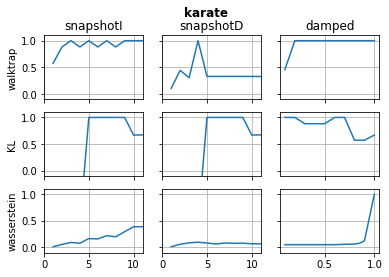

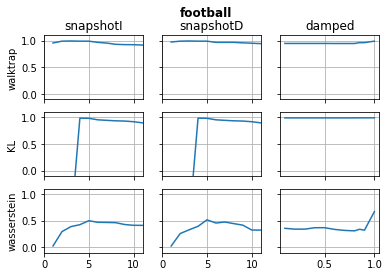

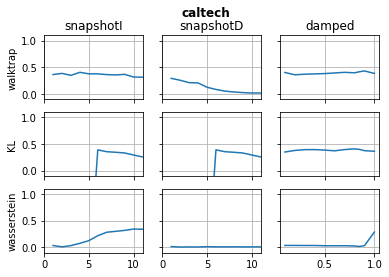

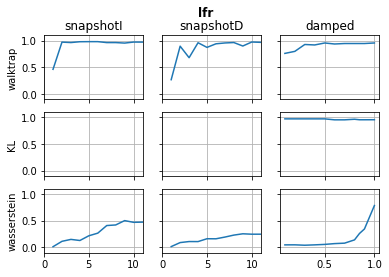

In [21]:
# plot results of above

def plot_experiment(name, total_ARI):
    with open(f'{name}.pkl', 'rb') as f:
        results = load(f)

    fig, axes = plt.subplots(nrows=3, ncols=3)
    fig.suptitle(name, fontweight='bold')
    colmap = {"snapshotI":0, "snapshotD":1, "damped":2}
    rowmap = {"walktrap":0, "KL":1, "wasserstein":2}
    
    bestARI = max(result[0] for result in results.values())
    lines = {}
    for label, result in sorted(results.items()):
#         print(f"{label:<25} {result[0]:.3f} {result[1]}")
        
        if result[0] == bestARI:
            print(f'TODO HIGHLIGHT {label}')
            
        split = label.split('_')
        if len(split)==3:
            ax_col = colmap[split[0]]
            ax_row = rowmap[split[1]]
            x = float(split[2].replace('p','.'))
            y = result[0]
            coord = (ax_row,ax_col)
            if coord not in lines.keys():
                lines[coord] = ([x], [y])
            else:
                lines[coord][0].append(x)
                lines[coord][1].append(y)
                
        if label not in total_ARI.keys():
            total_ARI[label] = result[0]
        else:
            total_ARI[label] += result[0]

    # plot lines and remove irrelevant ticks
    for coord,line in lines.items():
        axis = axes[coord[0],coord[1]]
        axis.plot(line[0], line[1])
        axis.set_ylim(-.1,1.1)
        axis.grid(True)
        
        if coord[0] < 2:
            axis.set_xticklabels(['' for _ in axis.get_xticklabels()])
        if coord[1] > 0:
            axis.set_yticklabels(['' for _ in axis.get_yticklabels()])
        if coord[1] < 2:
            axis.set_xlim(0,11)
        
    # label relevant axis
    for label,col in colmap.items():
        axes[0,col].title.set_text(label)
    for label,row in rowmap.items():
        axes[row,0].set_ylabel(label)


TODO HIGHLIGHT damped_KL_0p1
TODO HIGHLIGHT damped_KL_0p2
TODO HIGHLIGHT damped_KL_0p6
TODO HIGHLIGHT damped_KL_0p7
TODO HIGHLIGHT damped_walktrap_0p2
TODO HIGHLIGHT damped_walktrap_0p3
TODO HIGHLIGHT damped_walktrap_0p4
TODO HIGHLIGHT damped_walktrap_0p5
TODO HIGHLIGHT damped_walktrap_0p6
TODO HIGHLIGHT damped_walktrap_0p7
TODO HIGHLIGHT damped_walktrap_0p8
TODO HIGHLIGHT damped_walktrap_0p85
TODO HIGHLIGHT damped_walktrap_0p9
TODO HIGHLIGHT damped_walktrap_1
TODO HIGHLIGHT damped_wasserstein_1
TODO HIGHLIGHT jaccsp
TODO HIGHLIGHT snapshotD_KL_005
TODO HIGHLIGHT snapshotD_KL_006
TODO HIGHLIGHT snapshotD_KL_007
TODO HIGHLIGHT snapshotD_KL_008
TODO HIGHLIGHT snapshotD_KL_009
TODO HIGHLIGHT snapshotD_KL_100
TODO HIGHLIGHT snapshotD_walktrap_004
TODO HIGHLIGHT snapshotI_KL_005
TODO HIGHLIGHT snapshotI_KL_006
TODO HIGHLIGHT snapshotI_KL_007
TODO HIGHLIGHT snapshotI_KL_008
TODO HIGHLIGHT snapshotI_KL_009
TODO HIGHLIGHT snapshotI_KL_100
TODO HIGHLIGHT snapshotI_walktrap_003
TODO HIGHLIGHT sn

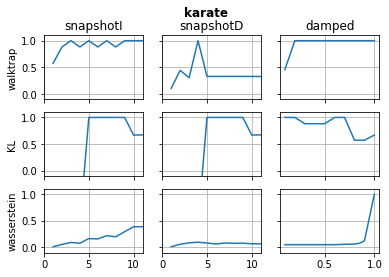

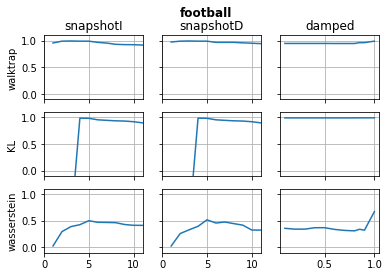

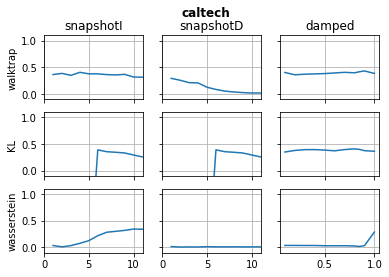

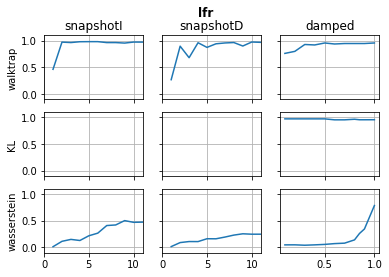

In [28]:
total_ARI = {}
plot_experiment('karate', total_ARI)
plot_experiment('football', total_ARI)
plot_experiment('caltech', total_ARI)
plot_experiment('lfr', total_ARI)

In [29]:
best = -1
argbest = None
for label,ari in total_ARI.items():
#     print(f"{label:<25} {ari:.3f}")
    if ari > best:
        best = ari
        argbest = label
print(argbest, best)

snapshotI_walktrap_005 3.35121963399413


In [30]:
def save_clustering(G, draw_dend=False):
    G = largest_connected_component(G)

    embedding = embed_snapshot_markov(G, 5, degrees=False)
    Z = cluster_walktrap(embedding, True)
    # Z = commute(G, True)
    print(eval_ARI(G, Z))

    if draw_dend:
        draw_dendrogram(G, Z)
    root = to_tree(Z)
    with open(f'dendrogram_{G.graph["name"]}.pkl', 'wb') as f:
        dump((G,root), f, HIGHEST_PROTOCOL)

(1.0, 2)
(0.9912266084718439, 14)
(0.37791646350546304, 22)
(0.982076562016823, 10)


/home/jz/.local/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


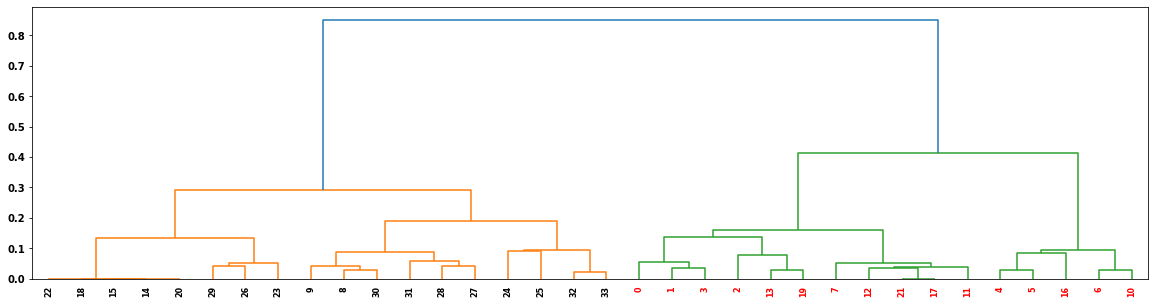

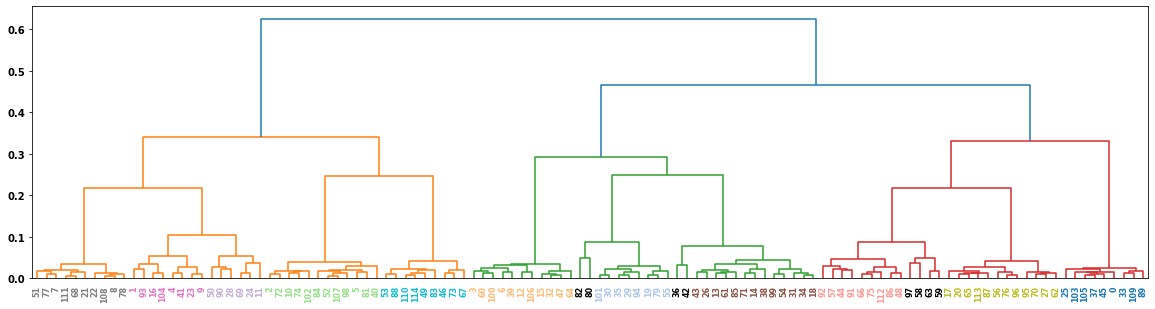

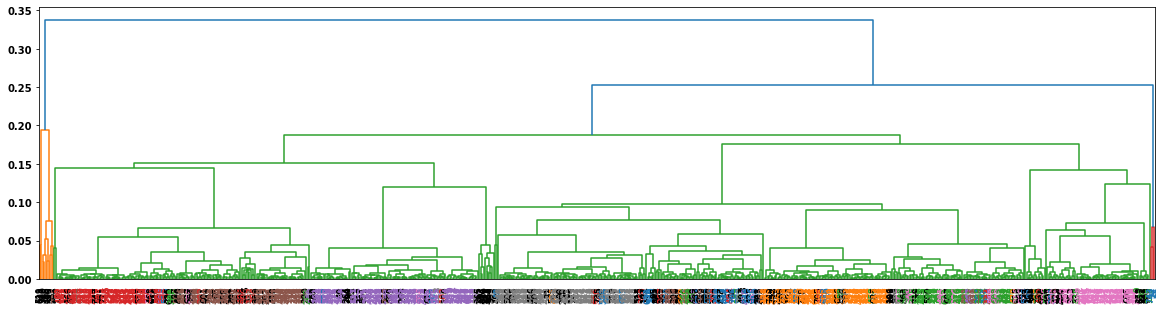

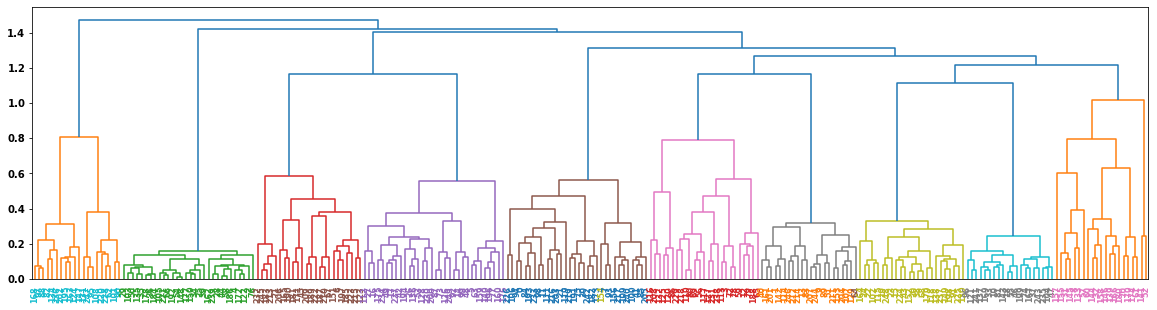

In [31]:
save_clustering(wrangle_karate(), 'karate')
save_clustering(wrangle_football(), 'football')
save_clustering(wrangle_caltech(), 'caltech')
save_clustering(generate_lfr(), 'lfr')